<a href="https://colab.research.google.com/github/KeyuLong96/DST5/blob/master/malicious_url_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install tldextract

In [0]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import gc
import random
import os
import pickle
import tensorflow as tf
from tensorflow.python.util import deprecation
from urllib.parse import urlparse
import tldextract

%tensorflow_version 1.x magic
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.x magic`. This will be interpreted as: `1.x`.


TensorFlow is already loaded. Please restart the runtime to change versions.


In [0]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import models, layers, backend, metrics
from tensorflow.keras.callbacks import EarlyStopping
from keras.utils.vis_utils import plot_model
from PIL import Image #python imaging library - openning modifying saving images
from sklearn.metrics import confusion_matrix, classification_report 

Using TensorFlow backend.


In [0]:
# set random seed
os.environ['PYTHONHASHSEED'] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
np.random.seed(0)
random.seed(0)
tf.random.set_seed(0)

In [0]:
# other setup
%config InlineBackend.figure_format = 'retina'
pd.set_option('max_colwidth', 500)
deprecation._PRINT_DEPRECATION_WARNINGS = False

Load data

In [0]:
from google.colab import files
uploaded = files.upload()
data = pd.read_csv('~/Documents/Datasets/malicious_url.csv')

Saving malicious_url.csv to malicious_url (1).csv


FileNotFoundError: ignored

In [0]:
tf.test.gpu_device_name()


'/device:GPU:0'

In [0]:
#load data
import io
data = pd.read_csv(io.BytesIO(uploaded['malicious_url.csv']))

In [0]:
data['label']=data['label'].replace('bad', 1)
data['label']=data['label'].replace('good', 0)

In [0]:
#shuffle data
data = data.sample(frac=1, random_state=0)
print(f'Data size: {data.shape}')
data.head()

Data size: (420464, 2)


,url,label
36210,a.kafunews.com/wp-includes/certificates/webmail.ccri.edu.html,1
77403,en.wikipedia.org/wiki/Claude_Lemieux,0
390133,www.jklgdf789dh43.com/7890890778yer/rtrtyr/rty/rty/ery/er.php?id=,1
356113,trulia.com/LA/New_Orleans/70115/,0
260369,ibikedb.net/bikes/27862-ccm-supercycle-thrill,0


In [0]:
val_size = 0.2
train_data, val_data = train_test_split(data, test_size=val_size, stratify=data['label'], random_state=123)
print(f'Train shape: {train_data.shape}, Validation shape: {val_data.shape}')

Train shape: (336371, 2), Validation shape: (84093, 2)


Data Analysis and Feature Engineering

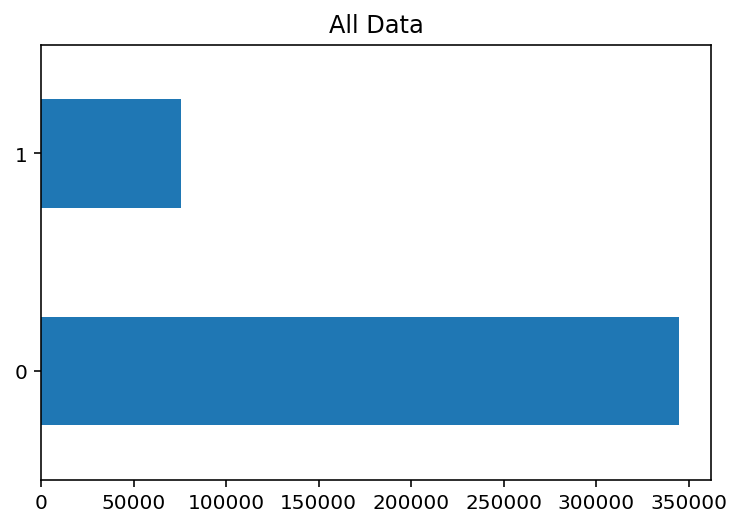

In [0]:
data.label.value_counts().plot.barh()
plt.title('All Data')
plt.show()

1 - bad url, 0 - good url

In [0]:
good, bad = data.label.value_counts()
print(f'Ratio of data between target labels (bad & good) is {bad//bad}:{good//bad}')

Ratio of data between target labels (bad & good) is 1:4


In [0]:
def parsed_url(url):
  #extract subdomain,domain, and domain suffix from url
  #if item == '', fill with '<empty>'
  subdomain, domain, domain_suffix = ('<empty>' if extracted == '' else extracted for extracted in tldextract.extract(url))
  return [subdomain, domain, domain_suffix]

In [0]:
def extract_url(data):
  #parsed url
  extract_url_data = [parsed_url(url) for url in data['url']]
  extract_url_data = pd.DataFrame(extract_url_data, columns=['subdomain', 'domain','domain_suffix'])
  #concat extracted feature with main data
  data = data.reset_index(drop=True)
  data = pd.concat([data, extract_url_data], axis=1)
  return data

In [0]:
train_data = extract_url(train_data)
val_data = extract_url(val_data)

In [0]:
def plot(train_data, val_data, column):
  plt.figure(figsize=(10, 17))
  plt.subplot(411)
  plt.title(f'Train data {column}')
  plt.ylabel(column)
  train_data[column].value_counts().head(10).plot.barh()
  plt.subplot(412)
  plt.title(f'Validation data {column}')
  plt.ylabel(column)
  val_data[column].value_counts().head(10).plot.barh()
  plt.subplot(413)
  plt.title(f'Train data {column} (groupped)')
  plt.ylabel(f'(label, {column})')
  train_data.groupby('label')[column].value_counts().head(10).plot.barh()
  plt.subplot(414)
  plt.title(f'Validation data {column} (groupped)')
  plt.ylabel(f'(label, {column})')
  val_data.groupby('label')[column].value_counts().head(10).plot.barh()
  plt.show()

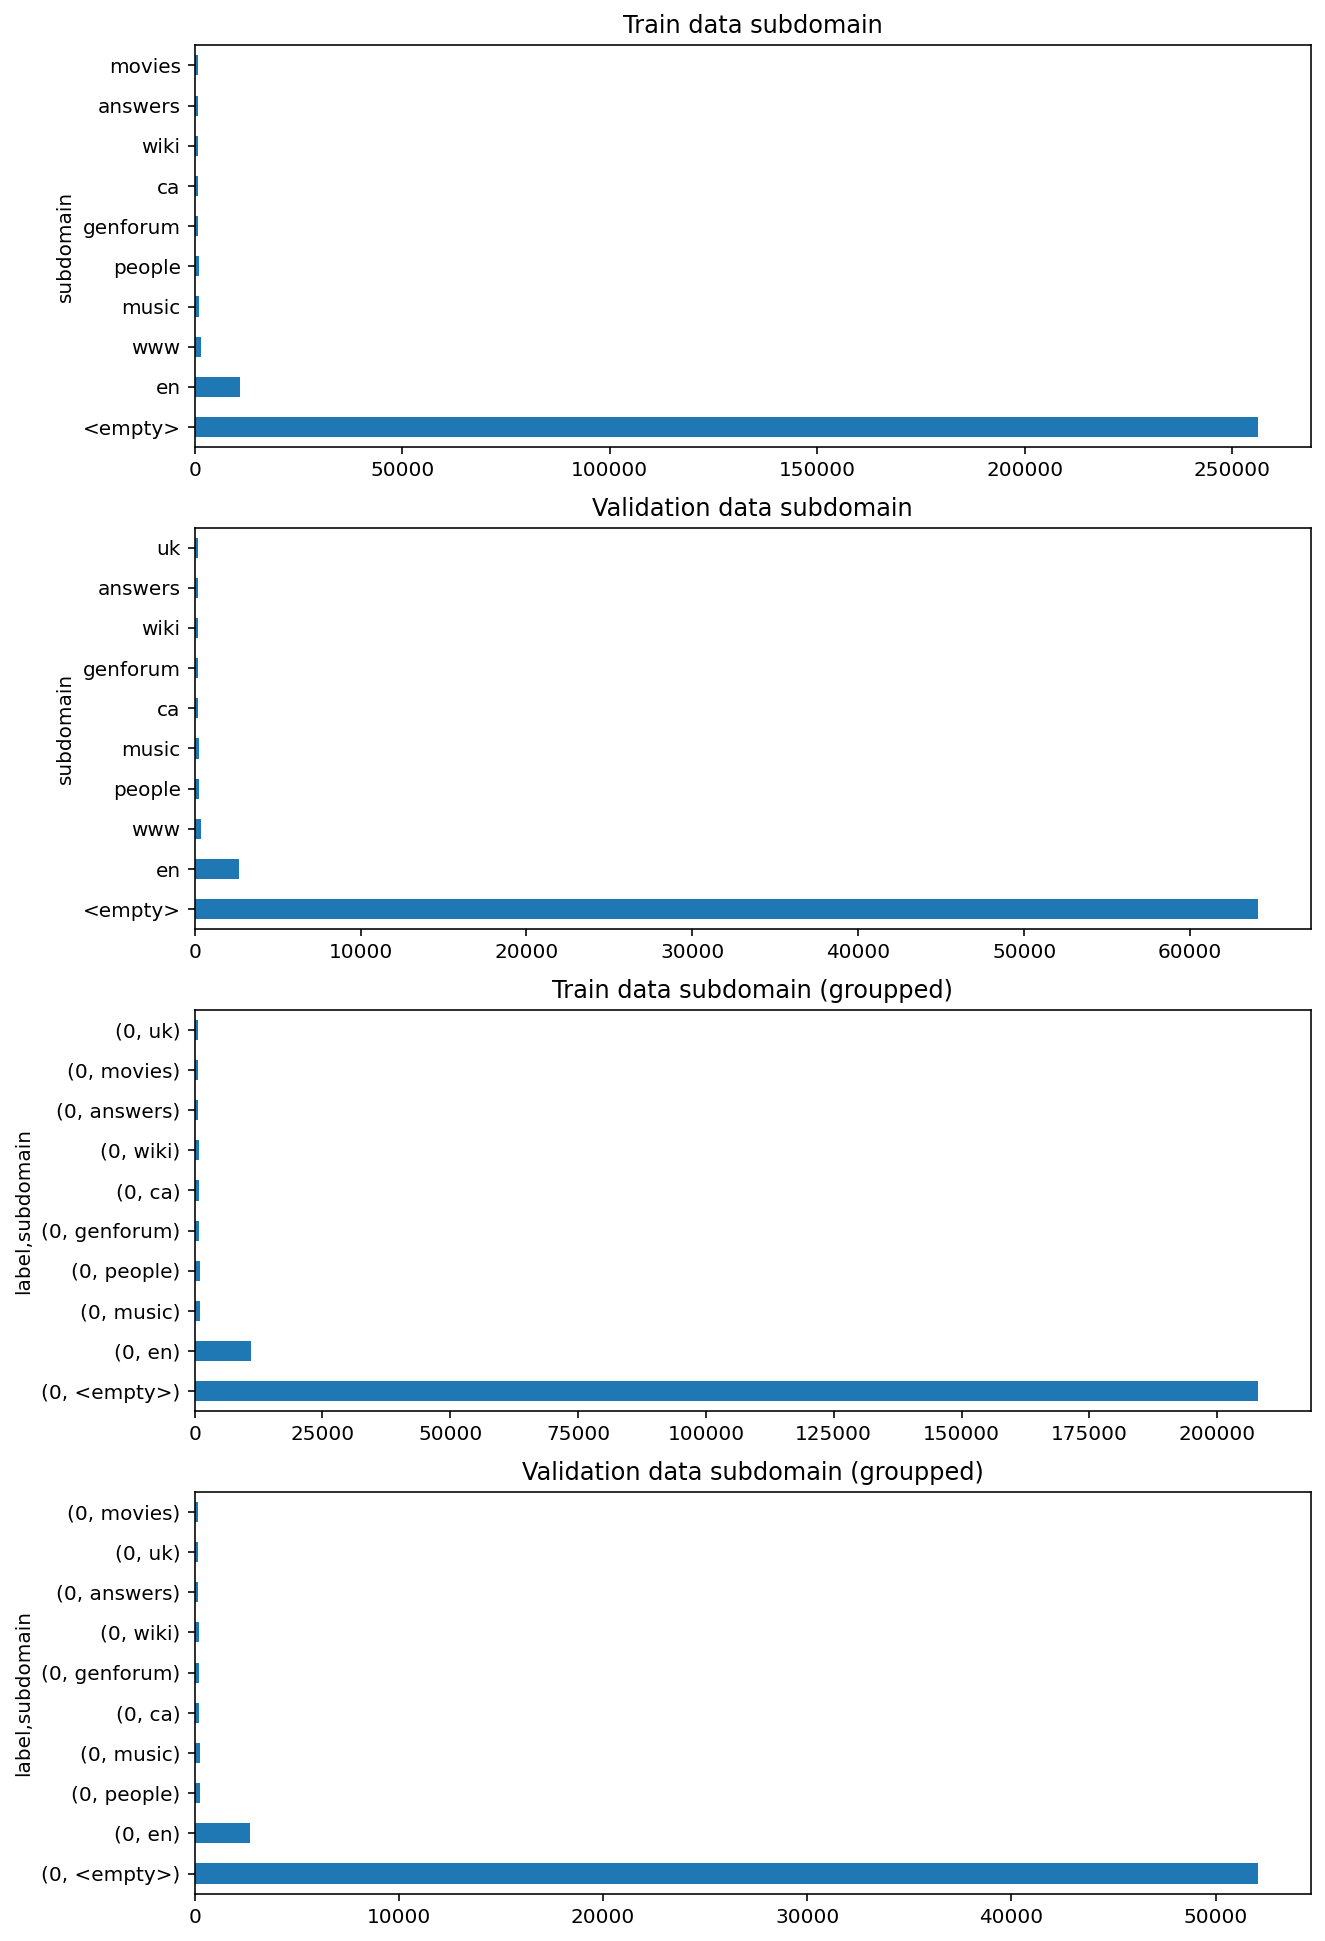

In [0]:
plot(train_data, val_data, 'subdomain')

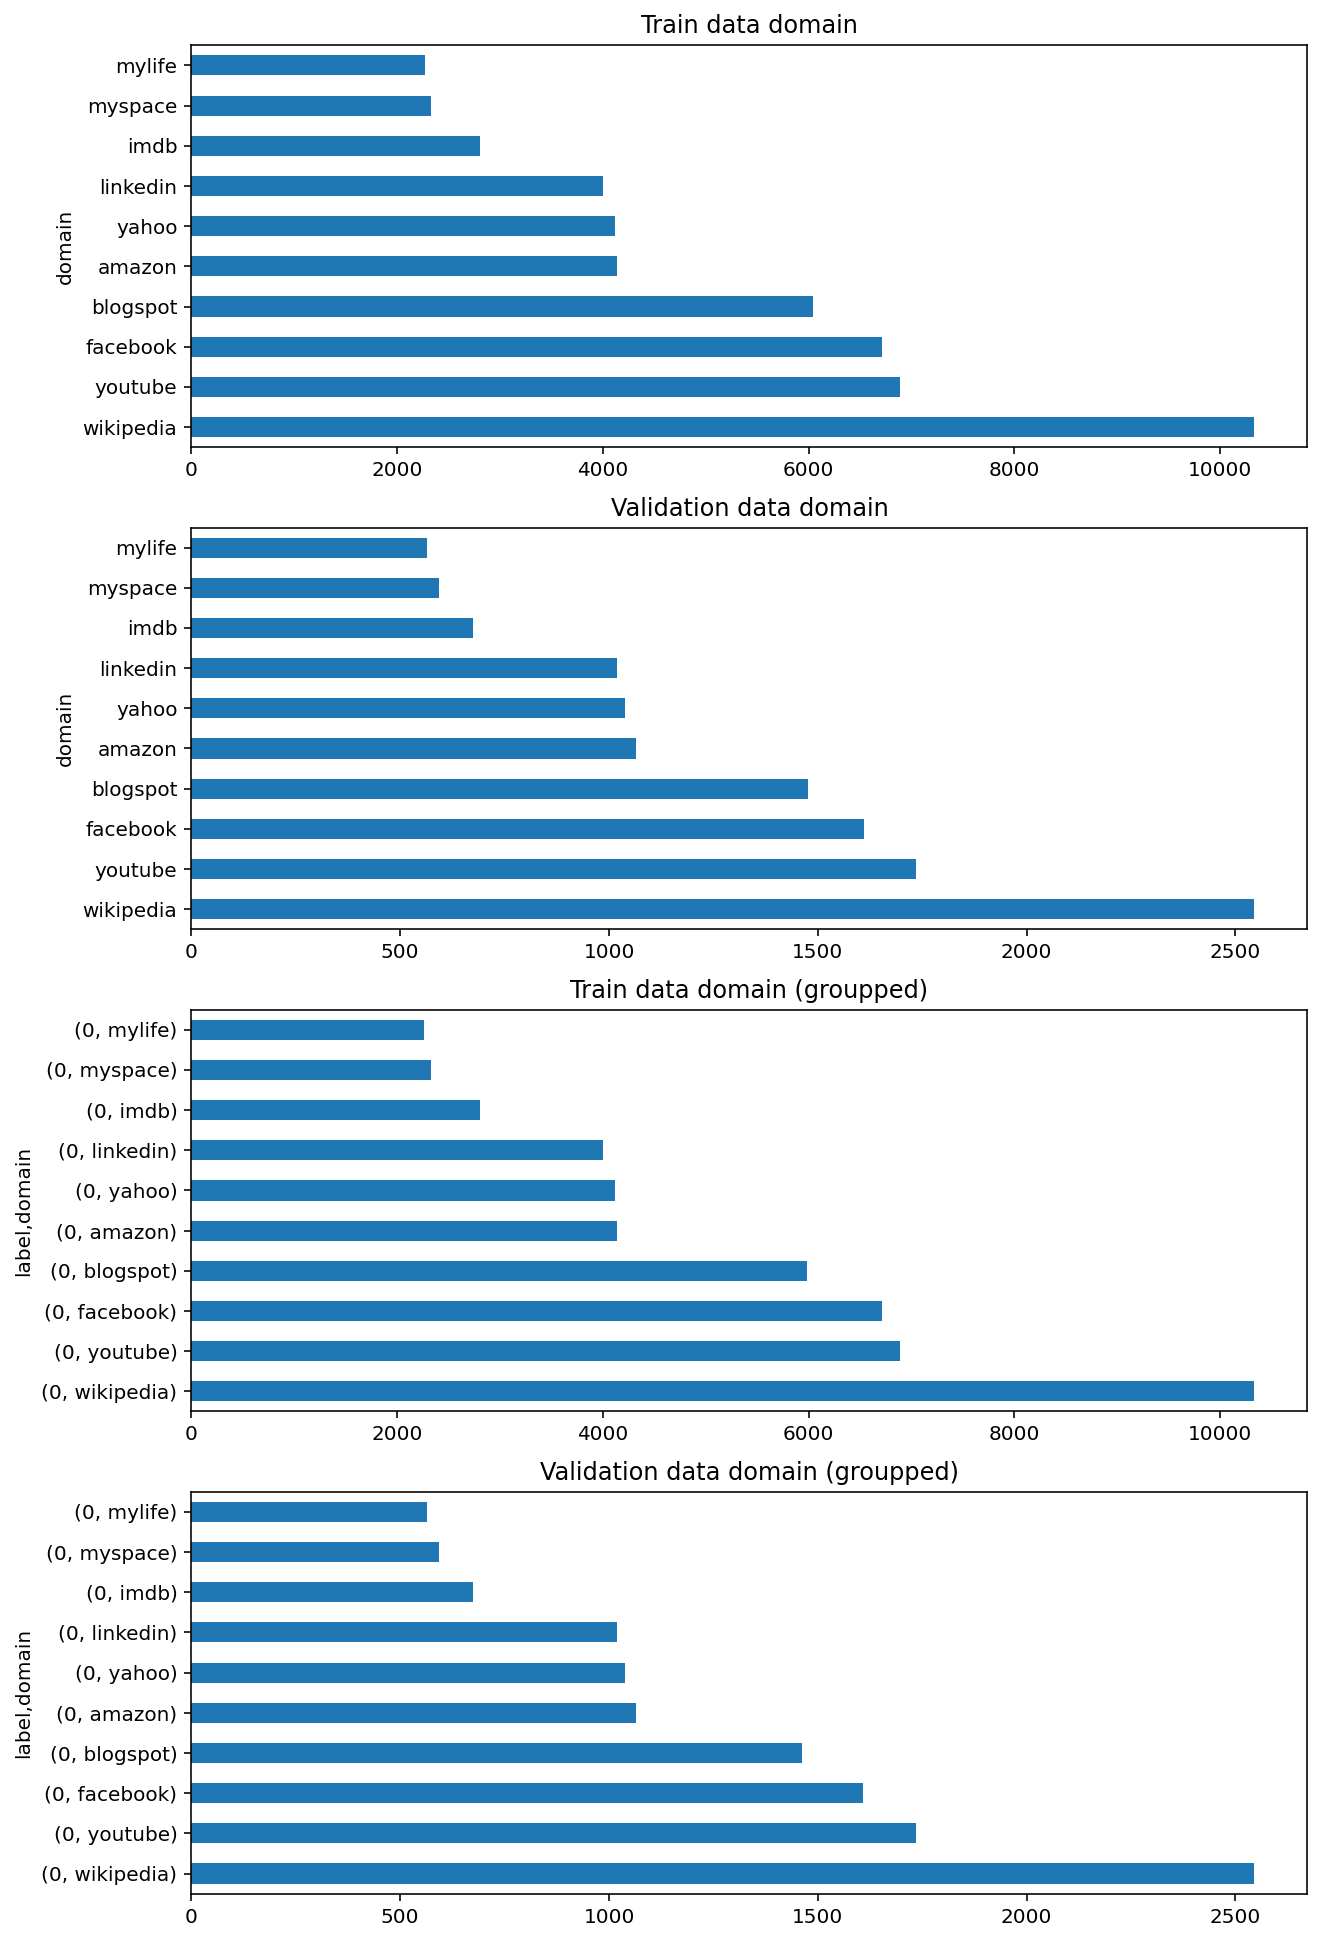

In [0]:
plot(train_data, val_data, 'domain')

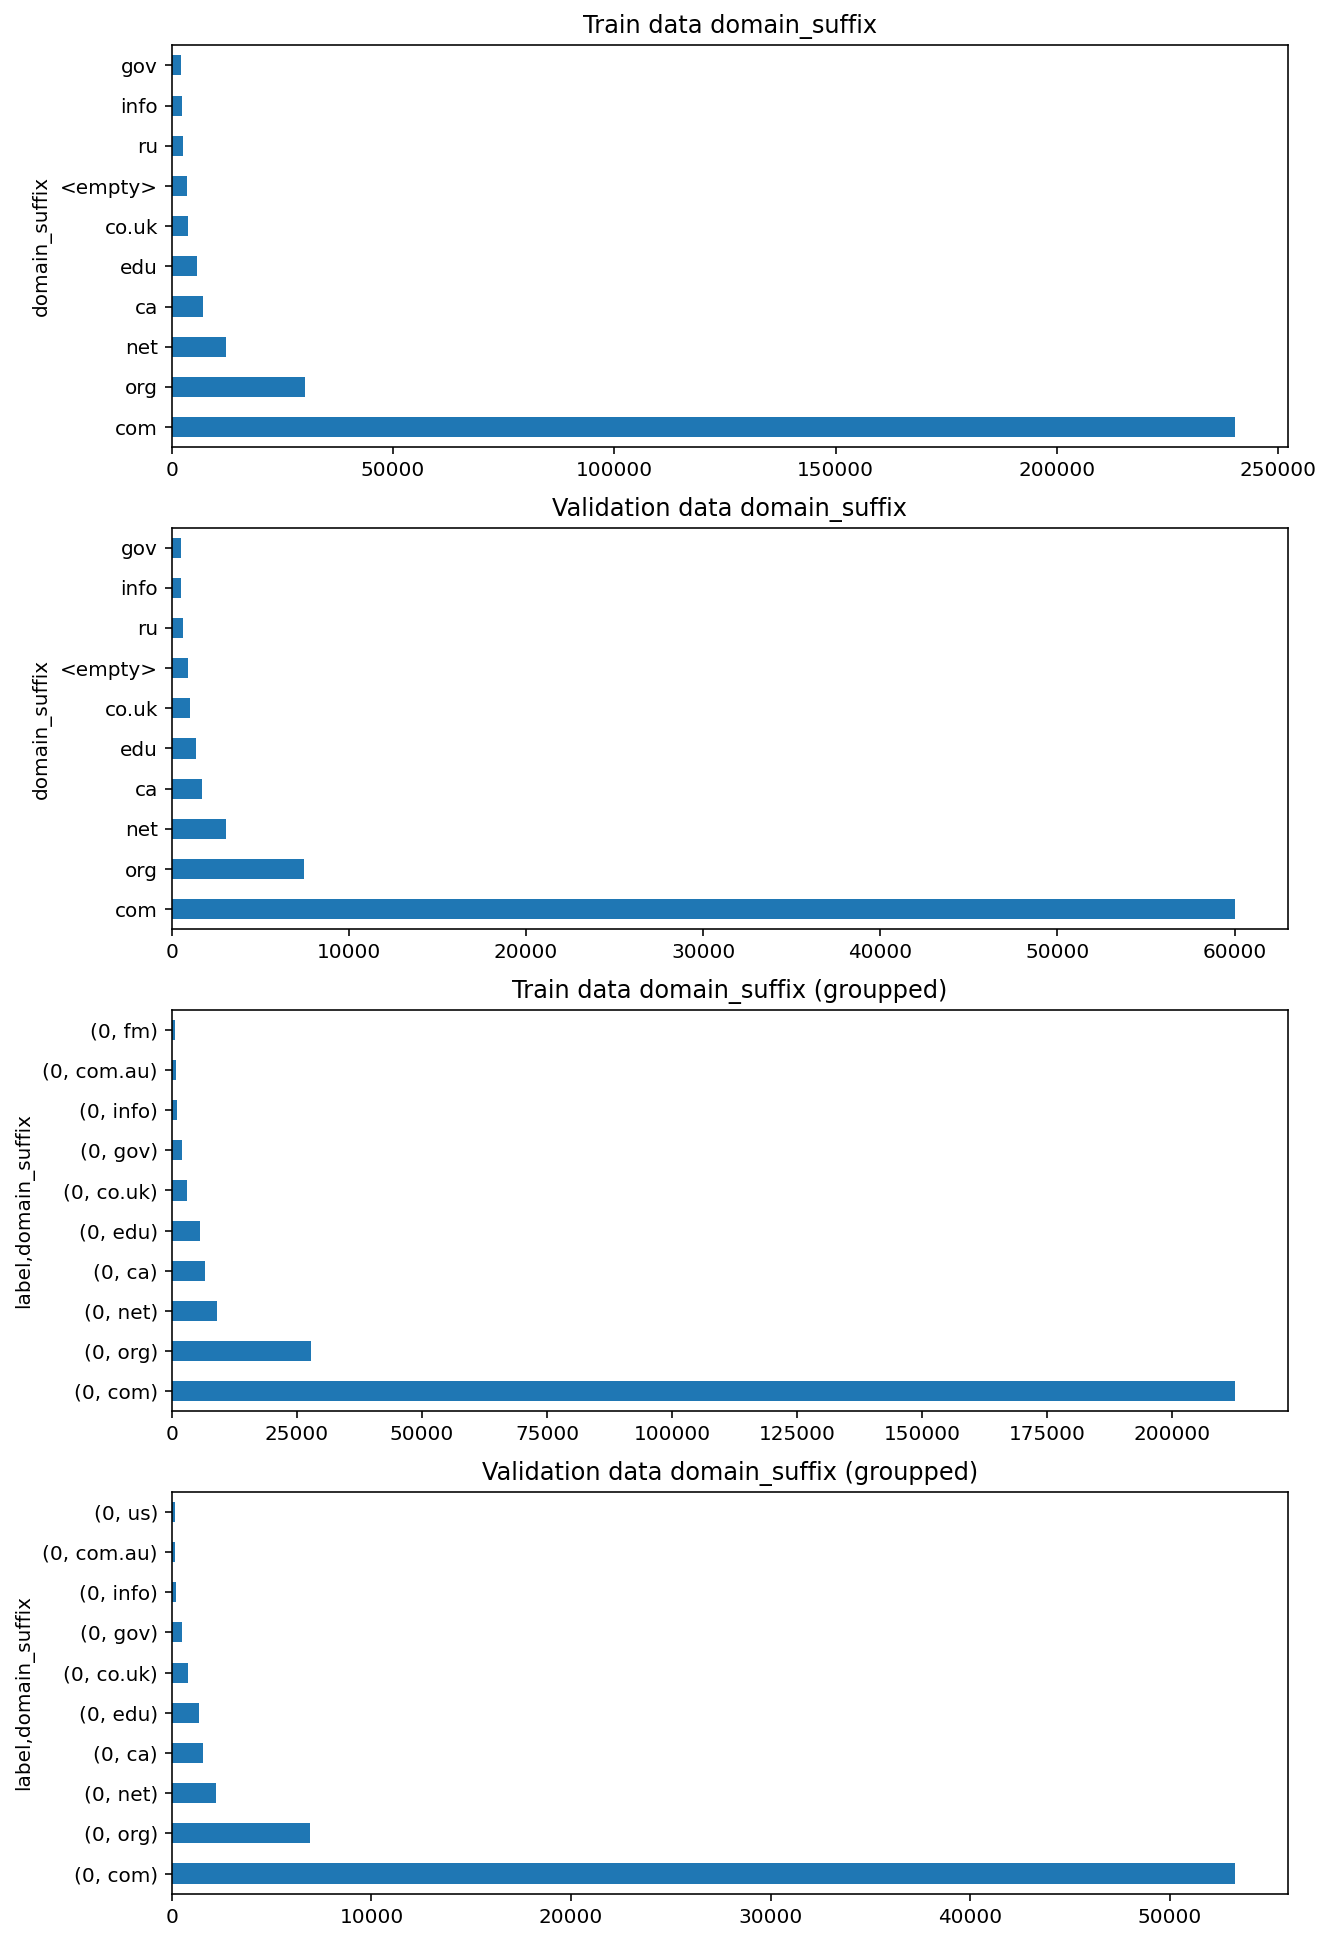

In [0]:
plot(train_data, val_data, 'domain_suffix')

In [0]:
train_data[(train_data['domain']=='google')&train_data['label']== 1].head() #displaying google domains that are malicious

,url,label,subdomain,domain,domain_suffix
2227,docs.google.com/forms/d/e/1FAIpQLSdcdE7lTEiqV5MW3Up8Hgcy5NGkIKnLKoe0YPFriD4_9qYq9A/formResponse,1,docs,google,com
4703,docs.google.com/uc?export=download&id=0B0EhrDpc7OqISkNnZy1Ia3RzT0k,1,docs,google,com
8434,docs.google.com/document/d/1-1buo7hGcqSRbCeoJ4OtbQkk0JjzkPEHULycAxHAbd0/pub,1,docs,google,com
9451,docs.google.com/uc?export=download&amp;id=0B5l5mUEw4-QxcUJEaE5WeWxrY2s,1,docs,google,com
11124,drive.google.com,1,drive,google,com


In [0]:
train_data[(train_data['domain'] == 'twitter') & (train_data['label']==1)].head() #displaying twitter malicious domains

,url,label,subdomain,domain,domain_suffix
1638,twitter.com/CcaunomKn9e4,1,<empty>,twitter,com
2145,twitter.com/mhuvluXr,1,<empty>,twitter,com
3503,twitter.com/gAxADMAMwA,1,<empty>,twitter,com
5951,twitter.com/tbYY979bU,1,<empty>,twitter,com
8503,twitter.com/QA5ADMA,1,<empty>,twitter,com


In [0]:
tokenizer = Tokenizer(filters='', char_level=True,lower=False, oov_token=1)
#fit only on training data
tokenizer.fit_on_texts(train_data['url'])
n_char = len(tokenizer.word_index.keys())
print(f'N Char: {n_char}')

N Char: 176


In [0]:
train_seq = tokenizer.texts_to_sequences(train_data['url'])
val_seq = tokenizer.texts_to_sequences(val_data['url'])
print('Before tokenization:' )
print(train_data.iloc[0]['url'])
print('\nAfter tokenization: ')
print(train_seq[0])

Before tokenization:
citytv.com/toronto/citynews/news/national/article/114078--tory-senator-s-social-network-finds-its-way-into-federal-posts

After tokenization: 
[8, 5, 7, 24, 7, 30, 13, 8, 3, 12, 6, 7, 3, 10, 3, 11, 7, 3, 6, 8, 5, 7, 24, 11, 2, 26, 9, 6, 11, 2, 26, 9, 6, 11, 4, 7, 5, 3, 11, 4, 14, 6, 4, 10, 7, 5, 8, 14, 2, 6, 23, 23, 32, 22, 37, 35, 15, 15, 7, 3, 10, 24, 15, 9, 2, 11, 4, 7, 3, 10, 15, 9, 15, 9, 3, 8, 5, 4, 14, 15, 11, 2, 7, 26, 3, 10, 28, 15, 25, 5, 11, 16, 9, 15, 5, 7, 9, 15, 26, 4, 24, 15, 5, 11, 7, 3, 15, 25, 2, 16, 2, 10, 4, 14, 15, 17, 3, 9, 7, 9]


In [0]:
sequence_length = np.array([len(i) for i in train_seq])
sequence_length = np.percentile(sequence_length, 99).astype(int)
print(f'Sequence length: {sequence_length}')

Sequence length: 161


In [0]:
train_seq = pad_sequences(train_seq, padding='post', maxlen=sequence_length)
val_seq = pad_sequences(val_seq, padding='post', maxlen=sequence_length)
print('After padding: ')
print(train_seq[0])
#displays tokenized data after padding

After padding: 
[ 8  5  7 24  7 30 13  8  3 12  6  7  3 10  3 11  7  3  6  8  5  7 24 11
  2 26  9  6 11  2 26  9  6 11  4  7  5  3 11  4 14  6  4 10  7  5  8 14
  2  6 23 23 32 22 37 35 15 15  7  3 10 24 15  9  2 11  4  7  3 10 15  9
 15  9  3  8  5  4 14 15 11  2  7 26  3 10 28 15 25  5 11 16  9 15  5  7
  9 15 26  4 24 15  5 11  7  3 15 25  2 16  2 10  4 14 15 17  3  9  7  9
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]


In [0]:
train_seq = train_seq / n_char
val_seq = val_seq / n_char

In [0]:
with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

In [0]:
def encode_label(label_index, data):
    try:
        return label_index[data]
    except:
        return label_index['<unknown>']

In [0]:
unique_value = {}
for feature in ['subdomain', 'domain', 'domain_suffix']:
    # get unique value
    label_index = {label: index for index, label in enumerate(train_data[feature].unique())}
    # add unknown label in last index
    label_index['<unknown>'] = list(label_index.values())[-1] + 1
    # count unique value
    unique_value[feature] = label_index['<unknown>']
    # encode
    train_data.loc[:, feature] = [encode_label(label_index, i) for i in train_data.loc[:, feature]]
    val_data.loc[:, feature] = [encode_label(label_index, i) for i in val_data.loc[:, feature]]
    # save label index
    with open(f'{feature}.pkl', 'wb') as f:
        pickle.dump(label_index, f)

In [0]:
print(f"Unique subdomain in Train data: {unique_value['subdomain']}")
print(f"Unique domain in Train data: {unique_value['domain']}")
print(f"Unique domain suffix in Train data: {unique_value['domain_suffix']}")

Unique subdomain in Train data: 23323
Unique domain in Train data: 98056
Unique domain suffix in Train data: 667


Create CNN model

In [0]:
def convolution_block(x):
    # 3 sequence conv layer
    conv_3_layer = layers.Conv1D(64, 3, padding='same', activation='elu')(x)
    # 5 sequence conv layer
    conv_5_layer = layers.Conv1D(64, 5, padding='same', activation='elu')(x)
    # concat conv layer
    conv_layer = layers.concatenate([x, conv_3_layer, conv_5_layer])
    # flatten
    conv_layer = layers.Flatten()(conv_layer)
    return conv_layer

In [0]:
def embedding_block(unique_value, size):
    input_layer = layers.Input(shape=(1,))
    embedding_layer = layers.Embedding(unique_value + 1, size, input_length=1)(input_layer)
    return input_layer, embedding_layer

In [0]:
def create_model(sequence_length, n_char, n_subdomain, n_domain, n_domain_suffix):
    input_layer = []
    # sequence input layer
    sequence_input_layer = layers.Input(shape=(sequence_length,))
    input_layer.append(sequence_input_layer)
    # convolution block
    char_embedding = layers.Embedding(n_char + 1, 32, input_length=sequence_length)(sequence_input_layer)
    conv_layer = convolution_block(char_embedding)
    # entity embedding
    entity_embedding = []
    for n in [n_subdomain, n_domain, n_domain_suffix]:
        size = 4
        input_l, embedding_l = embedding_block(n, size)
        embedding_l = layers.Reshape(target_shape=(size,))(embedding_l)
        input_layer.append(input_l)
        entity_embedding.append(embedding_l)
    # concat all layer
    fc_layer = layers.concatenate([conv_layer, *entity_embedding])
    fc_layer = layers.Dropout(rate=0.5)(fc_layer)
    # dense layer
    fc_layer = layers.Dense(128, activation='elu')(fc_layer)
    fc_layer = layers.Dropout(rate=0.2)(fc_layer)
    # output layer
    output_layer = layers.Dense(1, activation='sigmoid')(fc_layer)
    model = models.Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[metrics.Precision(), metrics.Recall()])
    return model

In [0]:
# reset session
backend.clear_session()
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(2342)
random.seed(24324)
tf.random.set_seed(243243)
# create model
model = create_model(sequence_length, n_char, unique_value['subdomain'], unique_value['domain'], unique_value['domain_suffix'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 161)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 161, 32)      5664        input_1[0][0]                    
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 161, 64)      6208        embedding[0][0]                  
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 161, 64)      10304       embedding[0][0]                  
______________________________________________________________________________________________

In [0]:
from tensorflow.keras.utils import plot_model

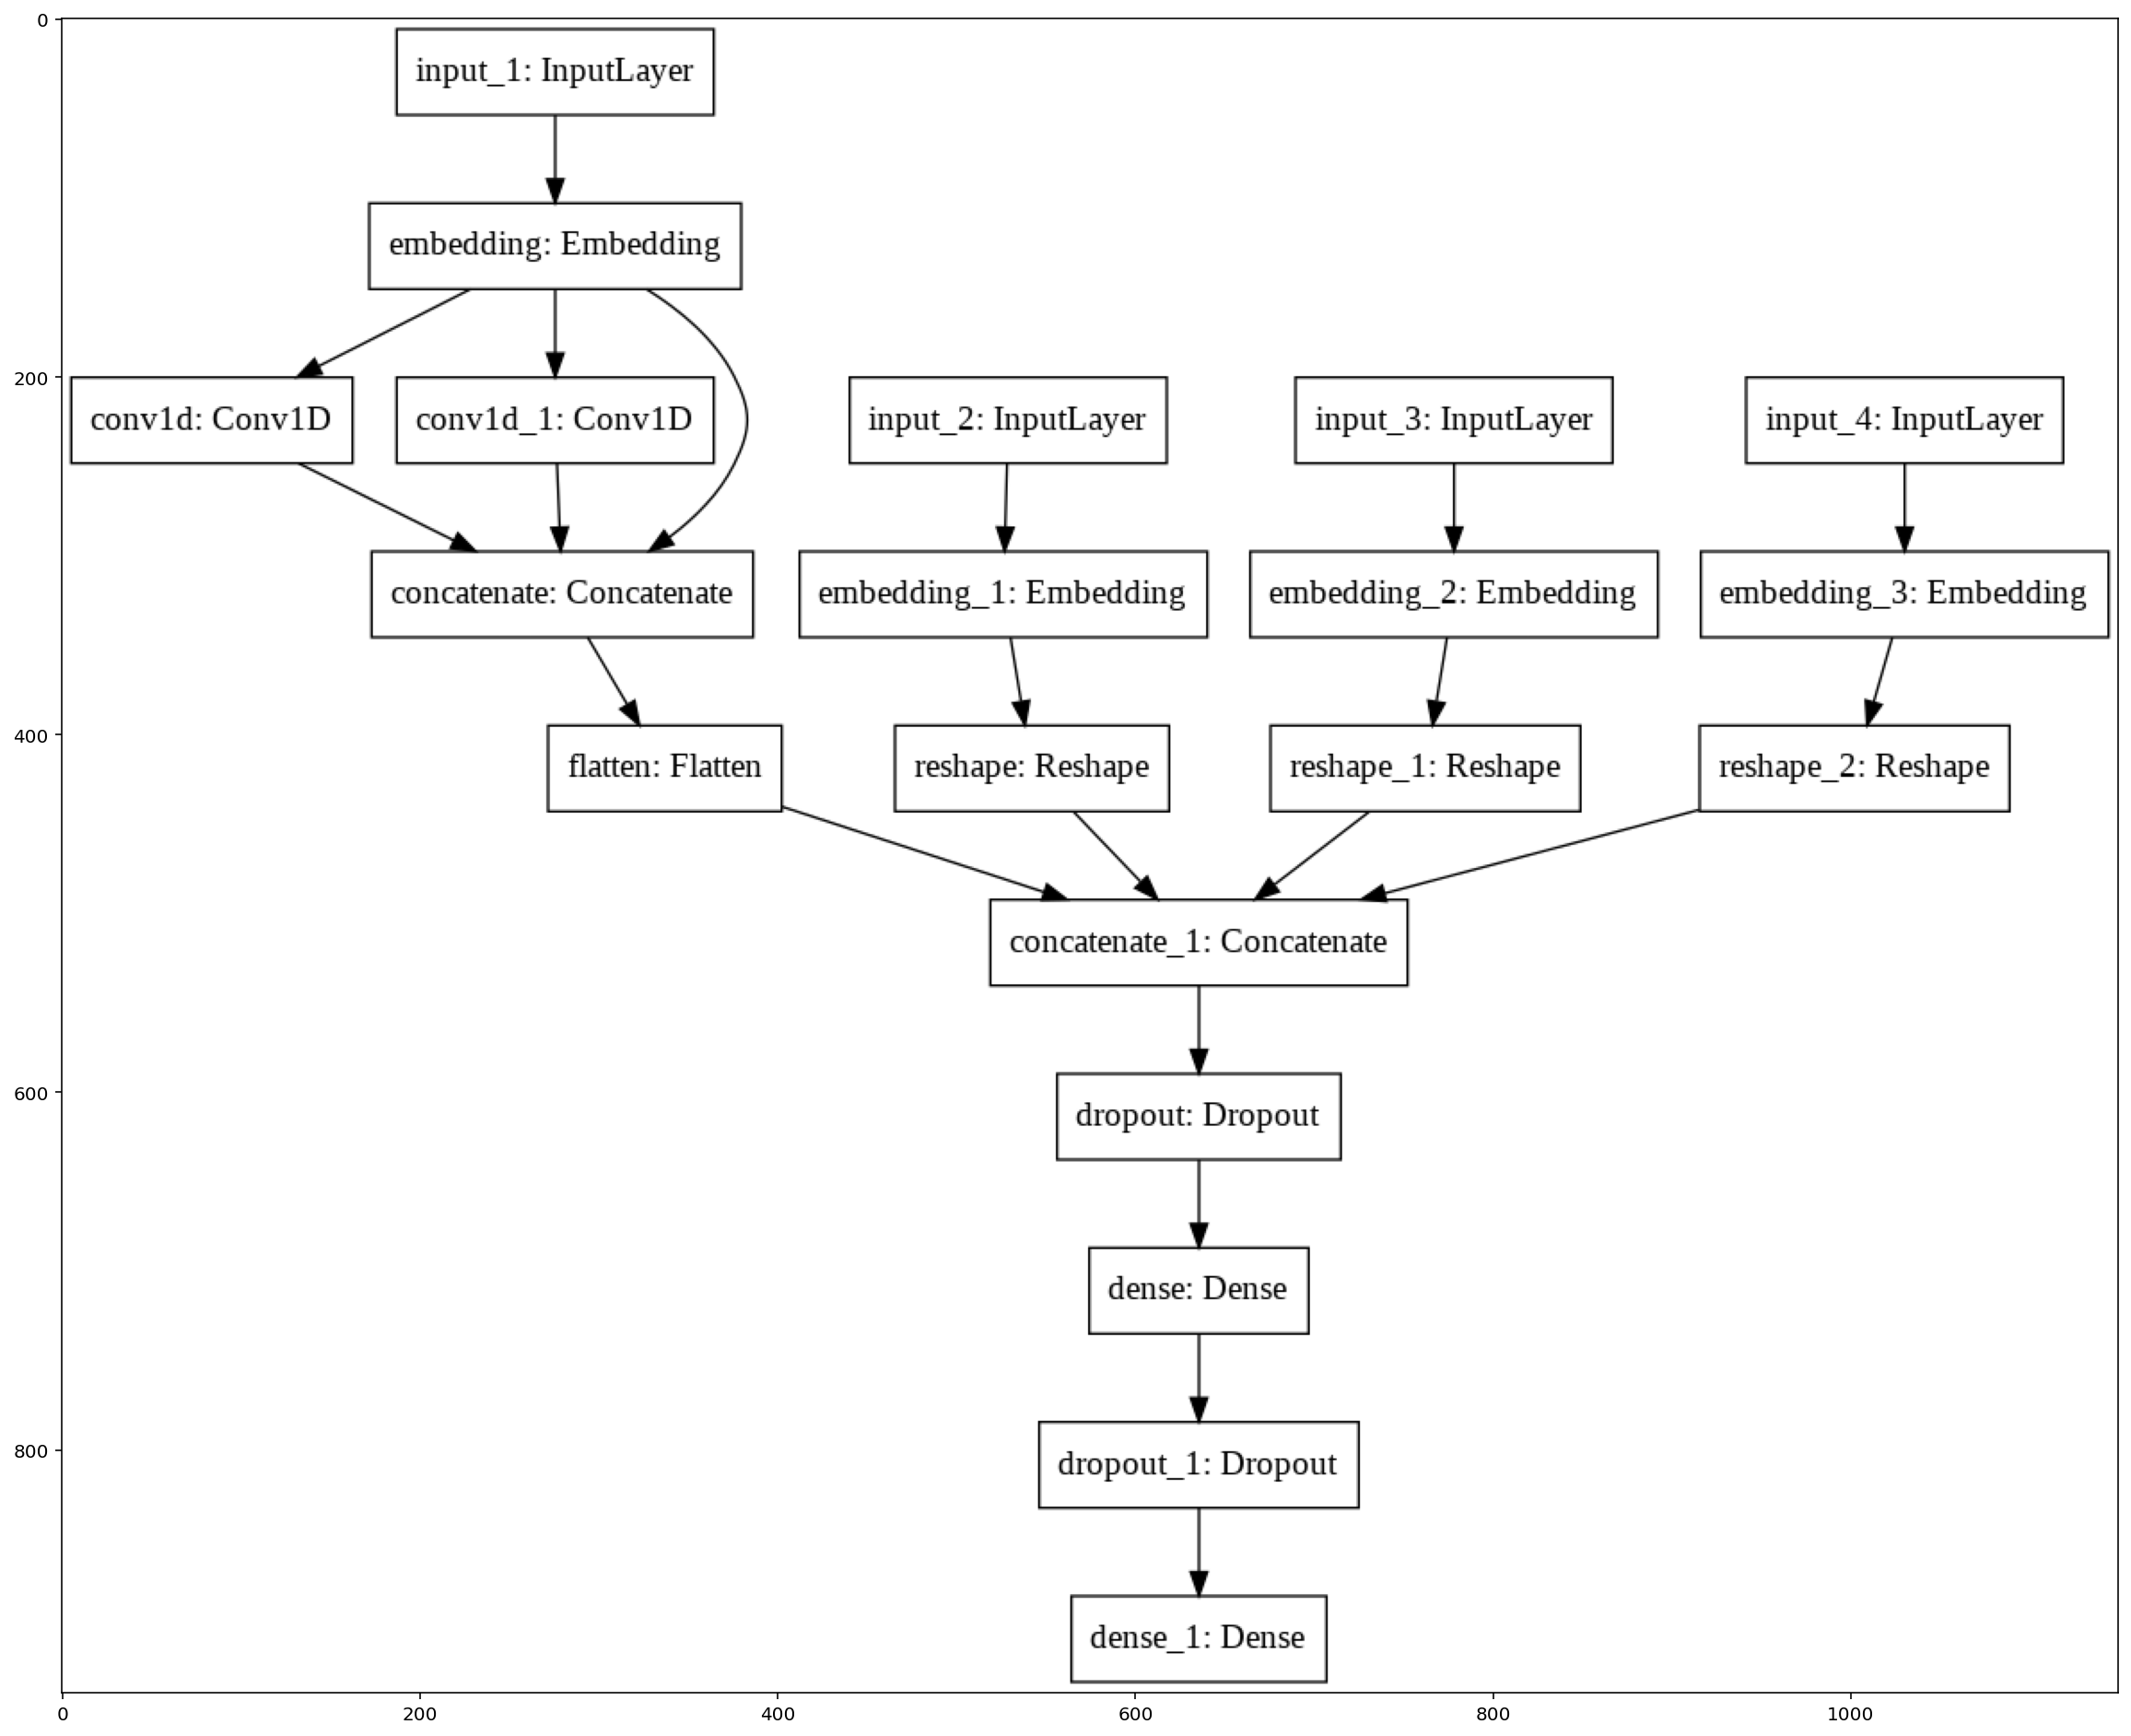

In [0]:
plot_model(model, to_file='model.png')
model_image = mpimg.imread('model.png')
plt.figure(figsize=(20, 20))
plt.imshow(model_image)
plt.show()

Model training

In [0]:
train_x = [train_seq, train_data['subdomain'], train_data['domain'], train_data['domain_suffix']]
train_y = train_data['label']
val_x = [val_seq, val_data['subdomain'], val_data['domain'], val_data['domain_suffix']]
val_y = val_data['label']

In [0]:
early_stopping = [EarlyStopping(monitor='val_precision', patience=5, restore_best_weights=True, mode='max')]
history = model.fit(train_x, train_y, batch_size=64, epochs=25, verbose=1, validation_data=[val_x, val_y], shuffle=True, callbacks=early_stopping)
model.save('model.h5')

Epoch 1/25
5256/5256 [==============================] - 92s 18ms/step - loss: 0.2511 - precision: 0.8373 - recall: 0.5323 - val_loss: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/25
5256/5256 [==============================] - 89s 17ms/step - loss: 0.1264 - precision: 0.9156 - recall: 0.8038 - val_loss: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/25
5256/5256 [==============================] - 90s 17ms/step - loss: 0.0762 - precision: 0.9558 - recall: 0.8870 - val_loss: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/25
5256/5256 [==============================] - 90s 17ms/step - loss: 0.0533 - precision: 0.9728 - recall: 0.9205 - val_loss: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/25
5256/5256 [==============================] - 89s 17ms/step - loss: 0.0416 - precision: 0.9817 - recall: 0.9383 - val_loss: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 6/25

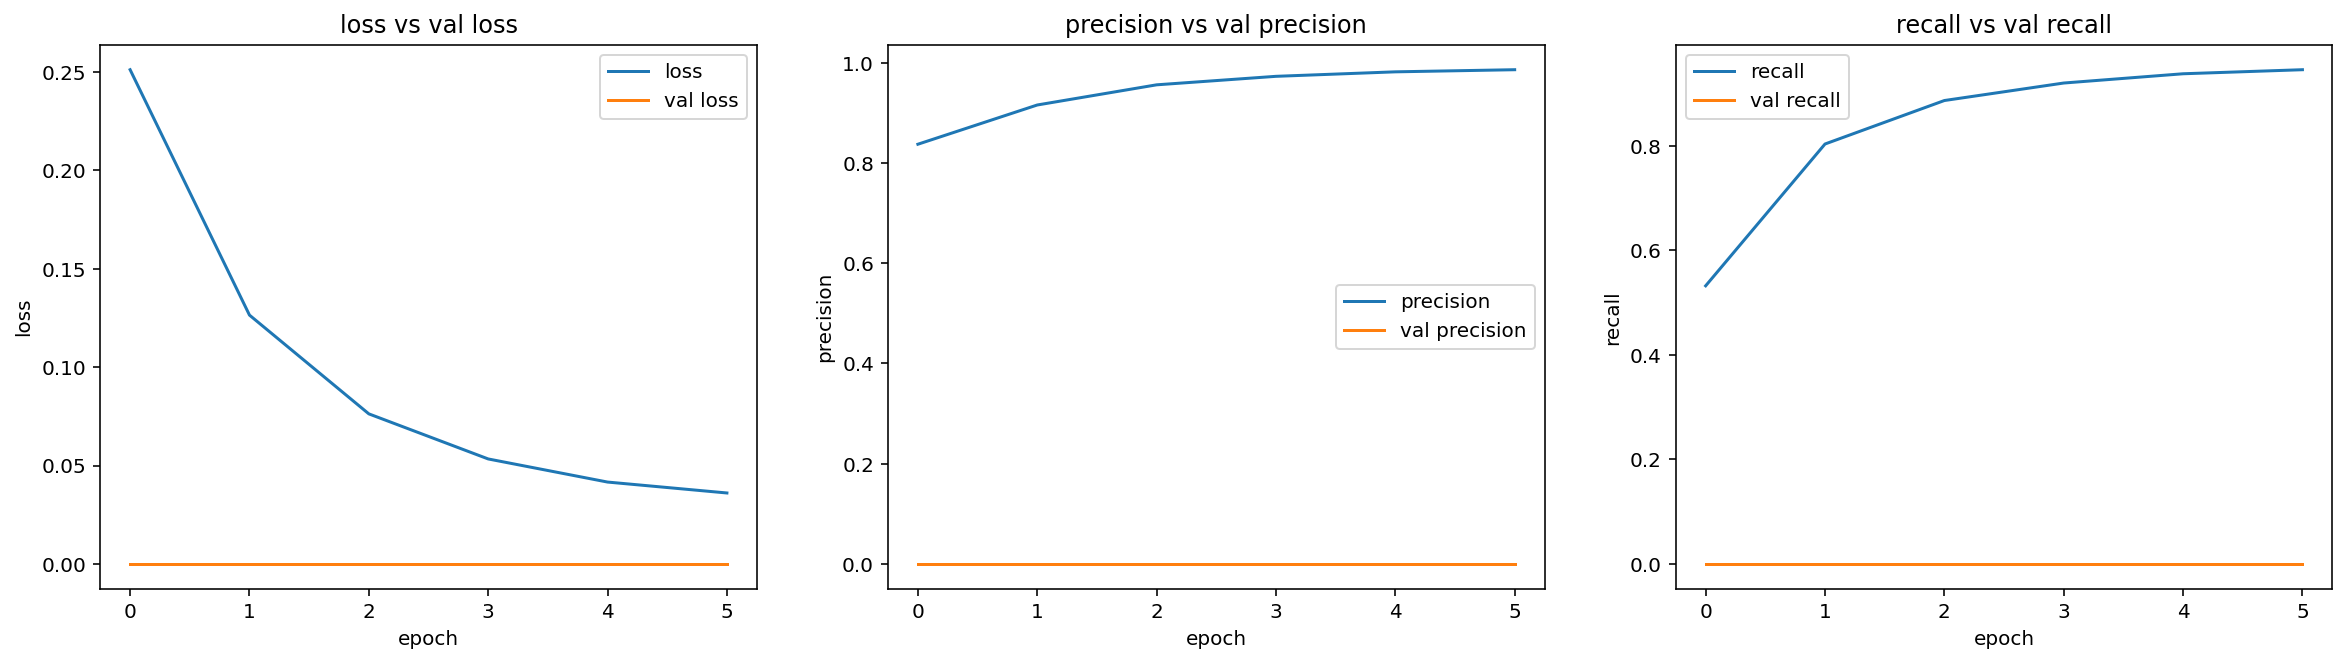

In [0]:
plt.figure(figsize=(20, 5))
for index, key in enumerate(['loss', 'precision', 'recall']):
    plt.subplot(1, 3, index+1)
    plt.plot(history.history[key], label=key)
    plt.plot(history.history[f'val_{key}'], label=f'val {key}')
    plt.legend()
    plt.title(f'{key} vs val {key}')
    plt.ylabel(f'{key}')
    plt.xlabel('epoch')

Model Validation

In [0]:
val_pred = model.predict(val_x)
val_pred = np.where(val_pred[:, 0] >= 0.5, 1, 0)
print(f'Validation Data:\n{val_data.label.value_counts()}')
print(f'\n\nConfusion Matrix:\n{confusion_matrix(val_y, val_pred)}')
print(f'\n\nClassification Report:\n{classification_report(val_y, val_pred)}')

Validation Data:
0    68964
1    15129
Name: label, dtype: int64


Confusion Matrix:
[[68340   624]
 [ 4345 10784]]


Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.99      0.96     68964
           1       0.95      0.71      0.81     15129

    accuracy                           0.94     84093
   macro avg       0.94      0.85      0.89     84093
weighted avg       0.94      0.94      0.94     84093



Transfer Learning - 
http://www.wildml.com/2015/11/understanding-convolutional-neural-networks-for-nlp/

https://blog.goodaudience.com/introduction-to-1d-convolutional-neural-networks-in-keras-for-time-sequences-3a7ff801a2cf

https://www.tensorflow.org/tutorials/images/transfer_learning

https://towardsdatascience.com/transfer-learning-from-pre-trained-models-f2393f124751

https://www.analyticsvidhya.com/blog/2018/11/tutorial-text-classification-ulmfit-fastai-library/?utm_source=blog&utm_medium=top-pretrained-models-nlp-article

https://www.analyticsvidhya.com/blog/2019/03/pretrained-models-get-started-nlp/

https://www.analyticsvidhya.com/blog/2018/11/tutorial-text-classification-ulmfit-fastai-library/

https://github.com/prateekjoshi565/ULMFiT_Text_Classification/blob/master/ULMFiT_fastai_Text_Classification.ipynb

Implementing ULMFiT

In [0]:
!pip install torch_nightly -f https://download.pytorch.org/whl/nightly/cu92/torch_nightly.html
!pip install fastai

Looking in links: https://download.pytorch.org/whl/nightly/cu92/torch_nightly.html
     |████████████████████████████████| 704.8MB 27kB/s 


In [0]:
# import libraries
import fastai
from fastai import *
from fastai.text import * 
from functools import partial
import io
import os

In [0]:
data=data.replace(1, 'bad')
data=data.replace(0, 'good')

In [0]:
train, val = train_test_split(data)

In [0]:
# Language model data
data_lm = TextLMDataBunch.from_df(path = "", train_df = train, valid_df = val,text_cols='url',label_cols='label')

In [0]:
#save the preprocessed data
data_lm.save()

In [0]:
#Classifier model data
data_clas = TextClasDataBunch.from_df(path = "", train_df = train, valid_df = val,text_cols='url',label_cols='label', vocab=data_lm.train_ds.vocab)

In [0]:
data_clas.save()

In [0]:
data_clas.show_batch()

text,target
xxbos mp3videosearch.com / mp3 / xxmaj frank - xxmaj marino - xxmaj mahogany - xxmaj rush - xxmaj babylon - xxmaj xxunk - xxmaj rush - xxmaj funky - xxmaj xxunk - xxmaj marino - xxmaj xxunk - xxmaj frank - xxmaj xxunk - xxmaj xxunk - xxmaj watson - xxmaj love - xxmaj xxunk - xxmaj xxunk - xxmaj want - xxmaj for - xxmaj christmas - xxmaj you,good
xxbos tomwatson.typepad.com / tom_watson / 2011 / 05 / we - were - watching - the - killing - xxunk - xxunk - seattle - murder - xxunk - drama - when - we - xxunk - the - tweets - about - an - xxunk - xxunk,good
xxbos xxunk / 2008 / 11 / 08 / kid - stuff / feels - like - kids - birthday - party - season - is - in - full - swing - in - morris - and - somerset - counties - new - jersey /,good
xxbos tvbythenumbers.zap2it.com / 2011 / 10 / 30 / tv - ratings - saturday - xxunk - xxunk - the - night - for - abc - americas - most - wanted - special - near - previous - seasons - ratings / xxunk /,good
xxbos 3blmedia.com / thecsrfeed / xxmaj world - xxmaj bank - and - xxmaj fair - xxmaj trade - xxup usa - xxmaj provide - xxmaj training - xxmaj colombian - xxmaj coffee - xxmaj producers - xxmaj price - xxmaj risk - xxmaj xxunk,good


In [0]:
data_clas.vocab.itos[:10]

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep',
 '/']

Fine-tuning and making predictions

In [0]:
#learn = language_model_learner(data_lm, pretrained_model=URLs.WT103, drop_mult=0.7)
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3, pretrained=True)

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.31E-02
Min loss divided by 10: 9.12E-02


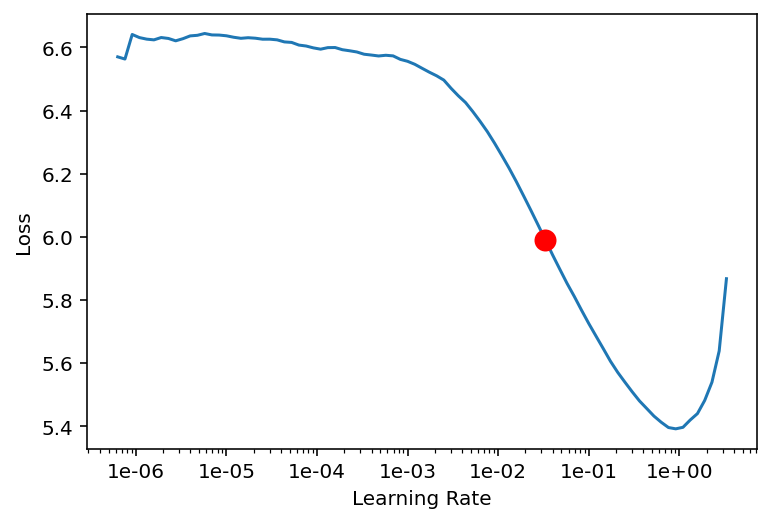

In [0]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [0]:
learn.fit_one_cycle(2, 5.7E-02, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,2.913828,2.510652,0.632032,08:20
1,2.462988,2.252096,0.660195,08:21


In [0]:
learn.save('fit_head')

In [0]:
learn.unfreeze()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.51E-05
Min loss divided by 10: 1.45E-04


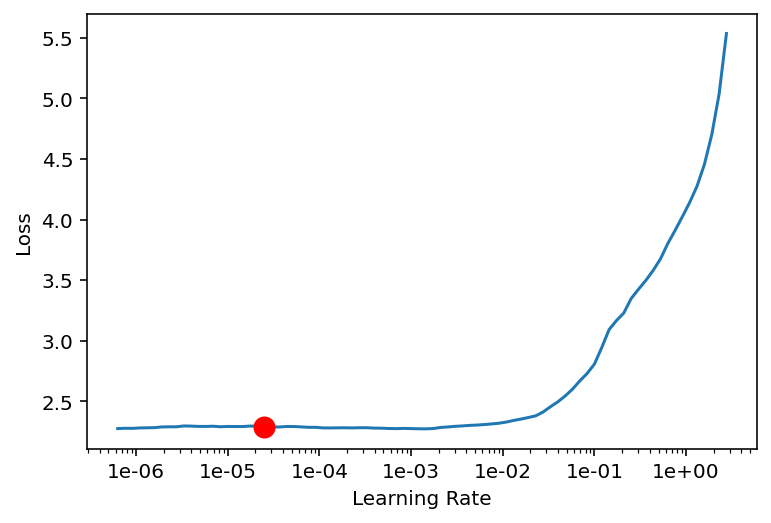

In [0]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [0]:
learn.fit_one_cycle(3,3.9E-04, callbacks=[SaveModelCallback(learn, name="best_lm")], moms=(0.8, 0.7))

NameError: ignored

In [0]:
learn.load('best_lm')

FileNotFoundError: ignored

In [0]:
learn.save_encoder('AIBoot_enc')

In [0]:
learn1=text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.3)

In [0]:
learn1.load_encoder('AIBoot_enc')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (315348 items)
x: TextList
xxbos imdb.com / character / xxunk /,xxbos cowboypoetry.com / miller.htm,xxbos dacompsc.com / modules / mod_custom / xxmaj acesso - xxmaj seguro - painel / xxmaj acesso - xxmaj seguro / identificacao - jsf / acesso /,xxbos rottentomatoes.com / celebrity / xxunk /,xxbos 7digital.com / artists / frank - xxunk ) / as - time - goes - by /
y: CategoryList
good,good,bad,good,good
Path: .;

Valid: LabelList (105116 items)
x: TextList
xxbos slovenia.info / ? xxunk,xxbos facebook.com / people / xxmaj anthony - xxmaj cornwall / xxunk,xxbos en.wikipedia.org / wiki / xxunk,xxbos nasa.gov / centers / xxunk / missions / xxunk,xxbos xxunk / career - advice / your - xxunk - your - brain - how - to - get - out - of - own - way
y: CategoryList
good,good,good,good,good
Path: .;

Test: None, model=SequentialRNN(
  (0): MultiBatchEncoder(
    (module): AWD_LSTM(
      (encoder): Embedding(60000, 400, padding_idx=1)
      (encod

In [0]:
learn1.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 7.59E-03
Min loss divided by 10: 5.25E-02


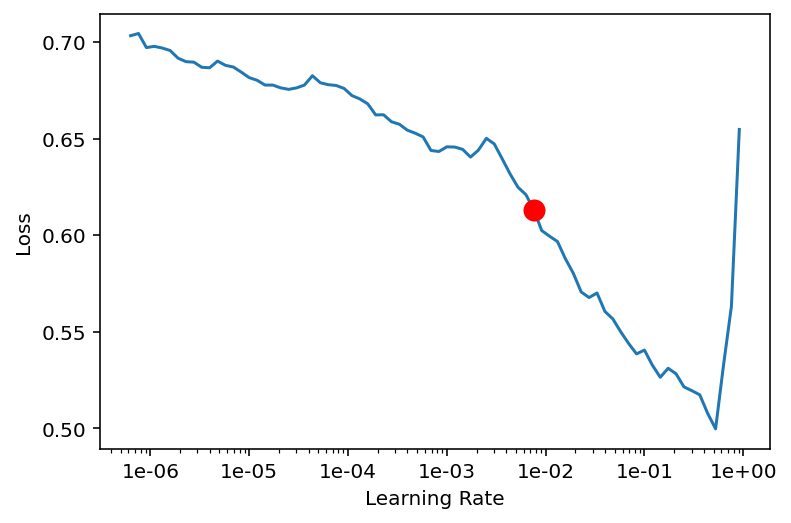

In [0]:
learn1.recorder.plot(suggestion=True)

In [0]:
best_clf_lr = learn1.recorder.min_grad_lr
best_clf_lr

0.007585775750291836

In [0]:
learn1.fit_one_cycle(1, best_clf_lr)

epoch,train_loss,valid_loss,accuracy,time
0,0.199285,0.169760,0.933711,03:03


In [0]:
learn1.freeze_to(-2)

In [0]:
learn1.fit_one_cycle(1, best_clf_lr)

epoch,train_loss,valid_loss,accuracy,time
0,0.135680,0.133481,0.949161,03:30


In [0]:
learn1.unfreeze()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Failed to compute the gradients, there might not be enough points.


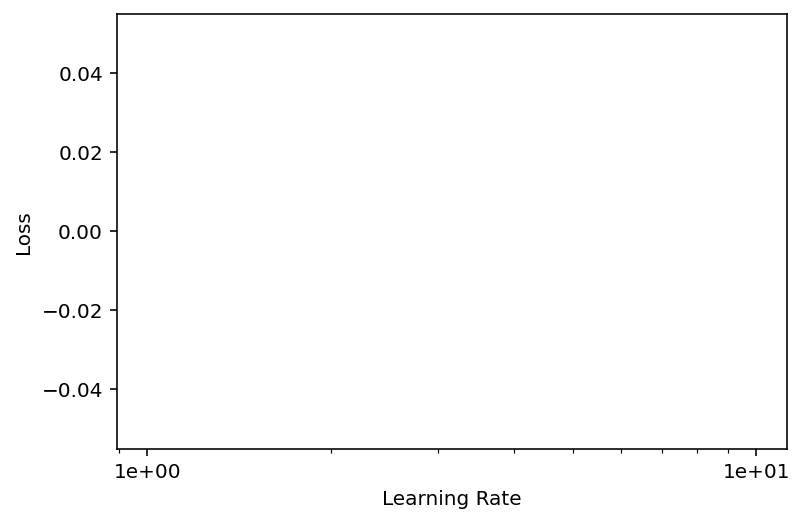

In [0]:
learn1.lr_find()
learn1.recorder.plot(suggestion=True)

In [0]:
learn1.fit_one_cycle(3, 2e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.129935,0.131154,0.950074,08:45
1,0.111362,0.105296,0.959597,09:13
2,0.073254,0.099908,0.963868,09:29


In [0]:
learn1.show_results()

text,target,prediction
xxbos xxunk / xxmaj about - us / xxmaj partners / xxmaj centre - xxmaj national - de - la - xxmaj recherche - xxmaj scientifique - xxup xxunk - xxmaj xxunk - xxmaj charles - xxmaj xxunk - de - l - xxmaj institut - d - xxmaj xxunk - xxup xxunk - xxup xxunk - xxmaj xxunk - xxmaj hubert - xxmaj xxunk - xxup xxunk - xxunk,good,good
xxbos houstonpress.com / 2011 - 11 - 17 / culture / capsule - art - reviews - book - report - if - you - xxunk - t - get - to - austin - to - see - the - texas - xxunk - xxunk - golf - experience - xxunk - xxunk - xxunk - matt - magee - new - xxunk - czech - avant - garde,good,good
xxbos ams1.ib.adnxs.com / if?enc = mzmzmzmzwz-5sqwck4e - xxunk xxrep 5 a xxunk xxrep 5 a xxunk xxrep 5 a xxunk xxrep 7 a dwp - abapubmpmzpg .. xxunk = xxunk = xxunk - xxunk xxrep 5 a xxunk xxrep 7 a g xxrep 4 a y xxrep 6 a xxup xxunk xxrep 4 a xxunk xxrep 6 a xxunk xxrep 70 a xxmaj xxunk xxrep 7 a xxunk xxrep 108,bad,bad
xxbos wh7w.com.cn / spool / products / class / ganda / zimitza / junems / lomo / xxunk : / / xxunk / xxunk = xxunk = xxunk = http : / / specs.openid.net / auth / 2.0 / xxunk = http : / / specs.openid.net / auth / 2.0 / xxunk = xxunk = http : / / specs.openid.net / auth / xxunk = http : / / specs.openid.net,bad,bad
xxbos slideshare.net / xxunk / b - r - i - e - f - h - i - s - t - o - r - y - o - f - e - n - g - l - i - s - h - a - n - d - a - m - e - r - i - c - a - n - l,good,good
